**Data: Хозяин руды**

В этом блокноте показана базовая модель для обучения поиска негабарита.

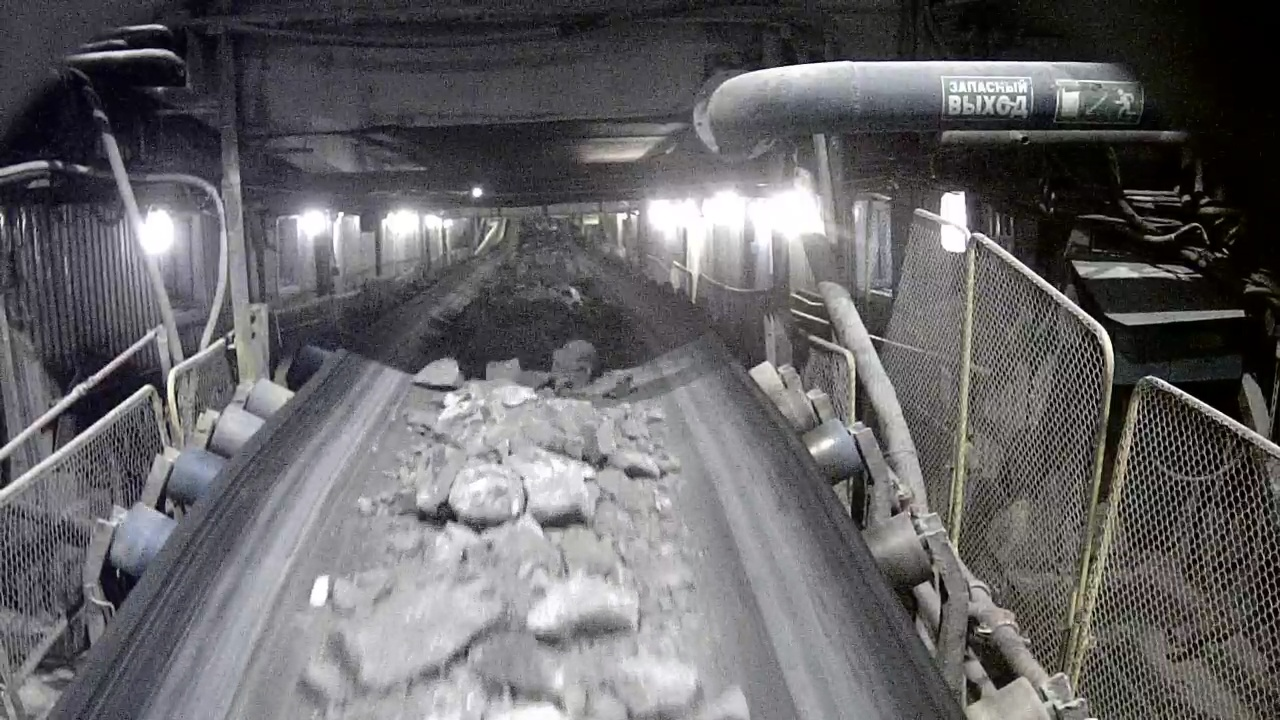

Результатом будет прогноз ограничевающих прямоугольников.

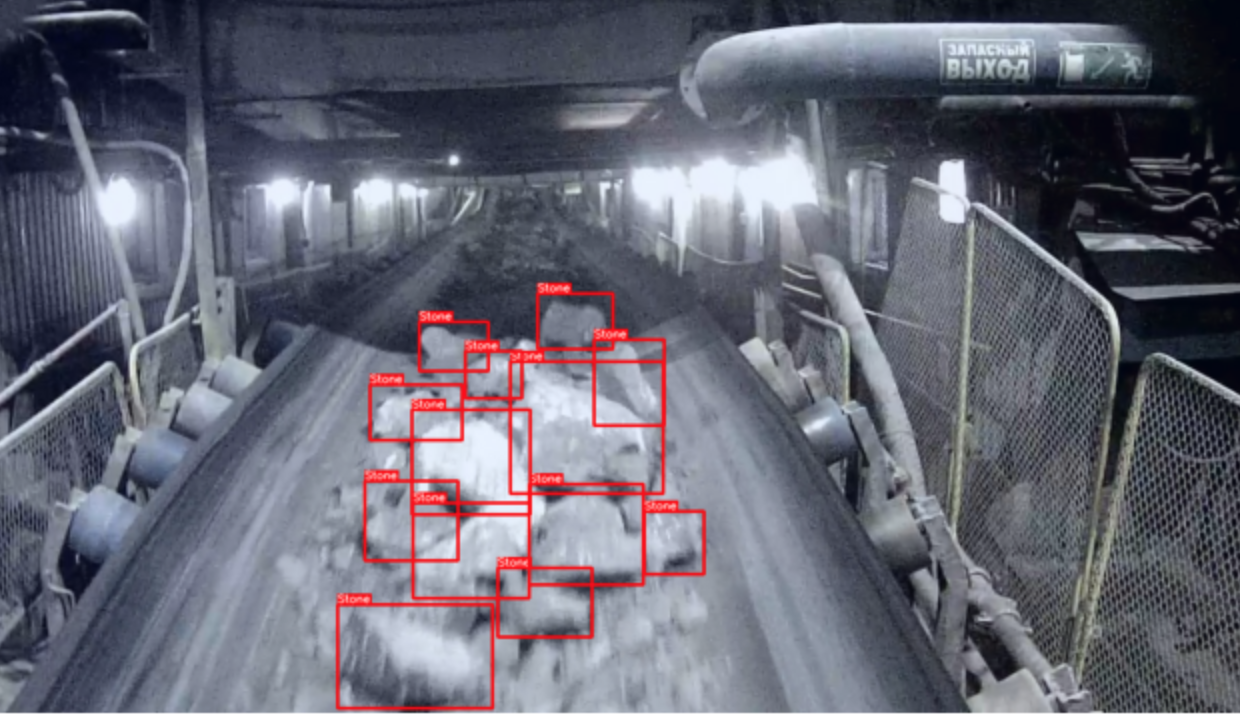




**Рекомендации по работе с проектом на хакатоне и идеи для развития:**
*   Данный блокнот имеет все базовые методы: загрузку датасета, обучение нейронной сети и выдача финального результата для загрузки на платформу.  Поэтому вам следует запустить все ячейки и убедиться, что вы правильно понимаете основную задачу.
*   Вы можете брать полностью этот проект за основу или создать свой с нуля. Можете использовать любой алгоритм, который посчитаете нужным. Не обязательно нейронную сеть.
*   Вам нужно увеличить точность работы нейронной сети или вашего алгоритма и максимально поднять итоговый скор.
*   Добавить классификацию величины блока исходя из размеров прямоугольника относительно ширины ленты. 7 классов брать из [таблицы (табл. 1)](https://pgenesis.notion.site/Data-de28e9bb758a4b608ac91ebf760feda3)
*   Продемонстрировать работу алгоритма в реалтайме на [видеопотоке mp4](https://drive.google.com/file/d/1IEx0YaCySK0rDy52wR6_KsiCWgC7wRTy/view?usp=sharing) - 
*   Если есть вопросы касательно этого блокнота, то пишите автору в телеграм [Владимиру](https://t.me/bums3230)
*   Приветсвуются любые идеи, которые могут касаться улучшения работы данного бизнес процесса. У экспертов трека можете получить фидбек о целесообразности ваших идей.

Топ-12 команд будут отобраны на питчи. Будет учитываться скор команд, а также идея решения и бизнес-ценность.

**Критерии оценки:**
*   50% - финальный скор. Корректность расположения ограничивающих прямоугольников.
*   30% - бизнес ценность. Классификации размеров гранул. Вычислислять размер гранул исходя из [таблицы (табл. 1)](https://pgenesis.notion.site/Data-de28e9bb758a4b608ac91ebf760feda3). Демонстрация работы алгоритма в реалтайме. 
*   10% - описание решения/документация. На сколько качественно описана архитектура решения, наличие сопроводительной документации. 
*   10% - презентация. На сколько понятно донесена идея и основные функции решения.


**Загружаем необходимые данные**

**Подготовка класса для загрузки датасета**

In [1]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
import json
import glob
import pandas as pd
import os
import ast

class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image|
        num_objs = len(coco_annotation)
        boxes = []

        try:
            for i in range(num_objs):
                xmin = coco_annotation[i]['bbox'][0]
                ymin = coco_annotation[i]['bbox'][1]
                xmax = xmin + coco_annotation[i]['bbox'][2]
                ymax = ymin + coco_annotation[i]['bbox'][3]
                boxes.append([xmin, ymin, xmax, ymax])
        except:
            pass
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd
        
        if self.transforms:
            augmented = self.transforms(image=np.asarray(img)) 
            img = augmented['image']
        return img, my_annotation, path

    def __len__(self):
        return len(self.ids)


In [2]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
import json
import glob
import pandas as pd
import os
import ast

class myOwnDataset_with_aug(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)
        boxes = []

        try:
            for i in range(num_objs):
                xmin = coco_annotation[i]['bbox'][0]
                ymin = coco_annotation[i]['bbox'][1]
                xmax = xmin + coco_annotation[i]['bbox'][2]
                ymax = ymin + coco_annotation[i]['bbox'][3]
                boxes.append([xmin, ymin, xmax, ymax])
        except:
            pass
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd
        
        if self.transforms:
            augmented = self.transforms(image=np.asarray(img),) 
            img = augmented['image']
        return img, my_annotation, path

    def __len__(self):
        return len(self.ids)


**Загрузка тренировочного, валидационного и публичного датасета**

In [3]:
import albumentations
import albumentations.pytorch


def get_transform_train():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

get_transform_train = albumentations.Compose([
    # crop left and right
    # albumentations.Crop(x_min=0, x_max=500, y_min=0, y_max=0, p=1.0),
    # crop top and bottom
    # albumentations.Crop(x_min=0, x_max=0, y_min=0, y_max=0, always_apply=False, p=0.5),
    
    # albumentations.OneOf([
                        #   albumentations.RandomBrightnessContrast(),
                        #   albumentations.HueSaturationValue()               
    # ], p=0.7),
    # albumentations.OneOf([
                        #   albumentations.MotionBlur(p=1),
                        #   albumentations.GaussNoise(p=1)                 
    # ], p=0.7),

    # albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    # albumentations.pytorch.transforms.ToTensorV2()
])

get_transform = albumentations.Compose([

            albumentations.OneOf(
            [
            albumentations.HorizontalFlip(p=1.0),
            albumentations.VerticalFlip(p=1.0),
            albumentations.RandomRotate90(p=1.0),
            #albu.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)

            ],p=0.5),
            
            albumentations.OneOf([
                                albumentations.RandomBrightnessContrast(),
                                albumentations.HueSaturationValue()               
            ], p=0.7),
            albumentations.OneOf([
                                albumentations.MotionBlur(p=1),
                                albumentations.GaussNoise(p=1)                 
            ], p=0.7),
    # albumentations.Crop(x_min = 200, y_min = 0, x_max = 900, y_max = 500, p=1.0),
    albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    albumentations.pytorch.transforms.ToTensorV2()

# my_transform = albumentations.Compose(
#     [albumentations.CenterCrop(height=280, width=280, p=1)],
#     bbox_params=albumentations.BboxParams(format='coco', min_visibility=0.3, label_fields=['category_ids']),
# )
])
def collate_fn(batch):
    return tuple(zip(*batch))
# Batch size
train_batch_size = 4


# Тренировочный датасет
train_data_dir = '../data/train'
train_coco = '../data/annot_local/train_annotation.json'

my_dataset = myOwnDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform,
                          

                          )
data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn)

# Локальный тестовый датасет
test_data_dir = '../data/train/'
test_coco = '../data/annot_local/test_annotation.json'

my_dataset_test = myOwnDataset(root=test_data_dir,
                          annotation=test_coco,
                          transforms=get_transform
                          )
data_loader_test = torch.utils.data.DataLoader(my_dataset_test,
                                          batch_size=2,
                                          shuffle=False,
                                          collate_fn=collate_fn)

# Публичный датасет для платформы 
public_data_dir = '../data/public/'
public_coco = '../data/annot_local/public_annotation_blank.json'

my_dataset_public = myOwnDataset(root=public_data_dir,
                          annotation=public_coco,
                          transforms=get_transform
                          )
data_loader_public = torch.utils.data.DataLoader(my_dataset_public,
                                          batch_size=1,
                                          shuffle=False,
                                          collate_fn=collate_fn)


loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
# private_data_dir = '/content/dataset/private/'
# private_coco = '/content/dataset/annot_local/private_annotation_blank.json'

# my_dataset_private = myOwnDataset(root=private_data_dir,
#                           annotation=private_coco,
#                           transforms=get_transform
#                           )
# data_loader_private = torch.utils.data.DataLoader(my_dataset_private,
#                                           batch_size=train_batch_size,
#                                           shuffle=False,
#                                           collate_fn=collate_fn)

**Инициализация нейронки и загрузка весов.**

In [6]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    # model.roi_heads.box_predictor = MaskRCNNPredictor(in_features,in_features, num_classes=num_classes)

    return model
    

num_classes = 2

model = get_model_instance_segmentation(num_classes)
model_path = r'C:\Users\Sergey\Documents\GitHub\coal-classification-miners\model\my_model_2_big_epoch_650_class_754.562441945076.pth'

try:
  model.load_state_dict(torch.load(model_path))
  print("Модель успешно загружена")
except:
  print("Erorr")

# move model to the right device
model.to(device)

Модель успешно загружена


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

**Обучение нейронной сети**

In [12]:
# is_train = False
# if is_train:
num_epochs = 7
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001)
# optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)
print(len_dataloader)
last_losses = 100000000
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    i = 0    
    for imgs, annotations, path in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        total_loss += losses.item()
        if(i%50 == 0):
            print(f'Iteration: {i}/{len_dataloader}, Loss: {total_loss / i}')
        torch.save(model.state_dict(), f'C:/Users/Sergey/Documents/GitHub/coal-classification-miners/model/my_model_2_big_epoch_{epoch}_class_{total_loss}.pth')
        print("Модель сохранена")
        print(total_loss)

650


c:\Users\Sergey\PycharmProjects\Test\venv\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


AssertionError: 

**Тут методы для сохранения результата в COCO JSON формате. Так же тут методы для визуализации работы нейросети**

In [7]:
from sahi.utils.coco import Coco, CocoCategory, CocoImage, CocoAnnotation
from sahi.utils.file import save_json
from PIL import Image
import re
import random

import cv2
from matplotlib import pyplot as plt

BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize("Stone", cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text="Stone",
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes,i):
    img = image.copy()
    for bbox in bboxes:
        img = visualize_bbox(img, bbox)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    #plt.imshow(img)
    #cv2.imwrite(f"C:/Users/Sergey/Documents/GitHub/coal-classification-miners/data/tmp/data_{i}.jpg", img)
    #plt.savefig(data_dir / "im.png")

def drawBBox(image, bboxes,i):
    bboxes = bboxes.cpu().detach().numpy().tolist()
    visualize(image, bboxes,i)

def checkAndSaveTestCocoJson(submission_path,test_dir_path,threshold,data_loader):
    coco = Coco()
    coco.add_category(CocoCategory(id=0, name='stone0'))
    coco.add_category(CocoCategory(id=1, name='stone1'))
    model = get_model_instance_segmentation(num_classes)
    counter = 0
    model.to(device)
    model.eval()
    i = 0
    train_batch_size = 1
    len_dataloader = len(data_loader)
    for imgs, annotations, paths in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        preds = model(imgs)
        print(f'Iteration: {i}/{len_dataloader}')
        for batch_item in preds:
            count_best_boxes = 1
            for score in batch_item['scores']:
              if score > threshold:
                count_best_boxes += 1

            boxes = batch_item['boxes'][:count_best_boxes]
            file_name=paths[counter%train_batch_size]
            image_id = int(re.findall(r'\d+', file_name)[0])
            print(image_id)
            print(file_name)
            coco_image = CocoImage(file_name=file_name, height=1080, width=1920, id=image_id)
            coco_image
            img = imgs[counter%train_batch_size].cpu().detach().numpy()
            img = ((img - img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')
            #images = cv2.imread(str(test_dir_path) + str("/")+str(file_name))

            # drawBBox(images,boxes,i)

            # continue
            for box in boxes:
                # print(test_dir_path)
                width, height = Image.open(test_dir_path +file_name).size
                x_min = box[0].item()
                y_min = box[1].item()
                width = box[2].item() - x_min
                height = box[3].item() - y_min
                coco_image.add_annotation(
                    CocoAnnotation(
                    bbox=[x_min, y_min, width, height],
                    category_id=1,
                    category_name='stone1',
                    image_id=image_id
                    )
                )
            coco.add_image(coco_image)
            print("counter", counter)
            counter += 1
            torch.cuda.empty_cache()
            
    save_json(data=coco.json, save_path=submission_path)


In [8]:
threshold = 0.99
submission_path = "/content/public_platform1.json"
dir_path = "/content/dataset/public/"
checkAndSaveTestCocoJson(submission_path,dir_path,threshold, data_loader_public)

def save_yolo():
    model = torch.hub.load('ultralytics/yolov5', 'custom',
                path=r'C:\Users\Sergey\Documents\GitHub\coal-classification-miners\model\best.pt')
    results = model(img)
    return results.render(), results.pandas().xyxy[0].to_json(orient="records")

c:\Users\Sergey\PycharmProjects\Test\venv\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration: 1/150
1250
frame1250.jpg


FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset/public/frame1250.jpg'

In [7]:
# cuda free memory


**Прогоняем тестовый датасет и сохраняем результат**

In [ ]:
threshold = 0.5
submission_path = "../data/test2.json"
dir_path = "../data/train/"
checkAndSaveTestCocoJson(submission_path,dir_path,threshold, data_loader_test)

**Прогоняем публичный датасет и сохраняем результат для загрузки на** [платформу](https://reg.polyus-hack.ru/)  

In [17]:
threshold = 0.99
submission_path = "/content/public_platform1.json"
dir_path = "/content/dataset/public/"
checkAndSaveTestCocoJson(submission_path,dir_path,threshold, data_loader_public)


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

**Прогоняем приватный датасет и сохраняем результат для загрузки на** [платформу](https://reg.polyus-hack.ru/)  

Это делать нужно будет в воскресенье (16 октября в 09:00). Приватный датасет размечен чуть более качественно. Поэтому скор может отличаться от публичного. И если будете замечать плохую разметку у тренировочного датасета, то можете корректировать вручную или использовать какие-то другие методы для исправления ошибок.

In [ ]:
threshold = 0.99
submission_path = "/content/private_platform.json"
dir_path = "/content/dataset/private/"
checkAndSaveTestCocoJson(submission_path,dir_path,threshold, data_loader_private)

**Считаем скор локального тестового датасета по целевой метрике**

In [ ]:
def closest_node(node, nodes):
    # Получение индекса ближайшей точки
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node) ** 2, axis = 1)
    return np.argmin(dist_2)

def get_all(true_bboxs: np.ndarray, pred_bboxs: np.ndarray):
    # Базовый расчет FP, FN
    # Получение ближайших центров квадратов для всех пар
    true = np.array([true_bboxs[:,0]+true_bboxs[:,2]/2, true_bboxs[:,1]+true_bboxs[:,3]/2]).T
    pred = np.array([pred_bboxs[:,0]+pred_bboxs[:,2]/2, pred_bboxs[:,1]+pred_bboxs[:,3]/2]).T
    
    true_cnt, pred_cnt = true.shape[0], pred.shape[0]
    if true_cnt < pred_cnt:
        FP = pred_cnt-true_cnt
        FN = 0
    elif true_cnt > pred_cnt:
        FN = true_cnt-pred_cnt
        FP = 0
    else:
        FP = FN = 0
    closet_inds = []
    if FP>=FN:
        for i in true:
            closet_inds.append(closest_node(i, pred))
    else:
        for i in pred:
            closet_inds.append(closest_node(i, true))
    return closet_inds, FP, FN

def bb_intersection_over_union(boxA_:np.ndarray, boxB_:np.ndarray):
    # Расчет IoU
    boxA, boxB = boxA_.copy(), boxB_.copy()
    # Корректировка формата (x,y,w,h) -> (x1,y1,x2,y2)
    boxA[2], boxB[2], boxA[3], boxB[3] = boxA[0]+boxA[2], boxB[0]+boxB[2], boxA[1]+boxA[3], boxB[1]+boxB[3]
    
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

# Юзать этот метод, он принимает два файла, который являются байтовыми словарями
def run(bytes_str_true, bytes_str_sub):
  annot = json.loads(bytes_str_true.decode("utf-8").replace("'",'"'))

  df_images_true = pd.DataFrame(annot['images'])
  df_annot_true = pd.DataFrame(annot['annotations'])

  annot = json.loads(bytes_str_sub.decode("utf-8").replace("'",'"'))

  df_images_sub = pd.DataFrame(annot['images'])
  df_annot_sub = pd.DataFrame(annot['annotations'])


  # обрабатываем ситуацию, когда пара file_name -- id
  # не соответствует в оригинальных и прогнозных файлах
  # df_images_true = df_images_true.set_index('file_name').sort_index()
  # df_images_sub = df_images_sub.set_index('file_name').sort_index()

  # df_images_sub.loc[:,'id']=df_images_true['id'].values


  iou=[]
  FP = FN =  0
  # Внешний цикл, проходит по всем кадрам
  for img_id in df_images_true['id'].values:
      true = np.array(list(df_annot_true[df_annot_true['image_id']==img_id]['bbox'].values))
      pred = np.array(list(df_annot_sub[df_annot_sub['image_id']==img_id]['bbox'].values))
      
      coord_inds, FP, FN = get_all(true, pred)
      # Внутренний цикл, считает IoU для пар
      for i,j in enumerate(coord_inds):
          if FN>+FP:
              iou.append(bb_intersection_over_union(true[j], pred[i]))
          else:
              iou.append(bb_intersection_over_union(pred[j], true[i]))
  iou = np.array(iou)
  FP += np.sum(iou<=0.5)
  TP = np.sum(iou>0.5)
  mIoU=np.mean(iou)
  beta = 2
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  fb = (((1+beta**2)*precision*recall)/((beta**2)*precision+recall))*mIoU
  print("Final score: ",fb) # ИТоговый результат метрики

def test():
  # Загрузка данных

  # загружаем оригинальные аннотации json и забираем необходимые части
  f = open('instances_default.json')
  annot = json.load(f)
  bytes_str_true = json.dumps(annot, indent=2).encode('utf-8') 

  # загружаем прогнозные аннотации json и забираем необходимые части
  f = open('submission.json')
  annot = json.load(f)
  bytes_str_sub = json.dumps(annot, indent=2).encode('utf-8')
  run(bytes_str_true, bytes_str_sub)
# test()

def getScoreSubmission(submission_path):
    # загружаем оригинальные аннотации json и забираем необходимые части
    f = open('/content/dataset/annot_local/test_annotation.json')
    annot = json.load(f)
    bytes_str_true = json.dumps(annot, indent=2).encode('utf-8') 

    # загружаем прогнозные аннотации json и забираем необходимые части
    f = open(submission_path)
    annot = json.load(f)
    bytes_str_sub = json.dumps(annot, indent=2).encode('utf-8')
    run(bytes_str_true, bytes_str_sub)
getScoreSubmission("/content/test.json")

Final score:  0.6253290763384872


In [ ]:
import numpy


def test_baseliner():
    fid_varian.baseliner()
    if not hasattr(fid_varian, '_bl_ppm') or fid_varian._bl_ppm is None:
        ppm = fid_varian._ppm
        narr = numpy.linspace(ppm[0], ppm[-2], 5)
        fid_varian._bl_ppm = narr
    fid_varian.real()
    fid_varian.baseline_correct()
    fid_array_varian.baseliner_fids()